In [1]:
import os
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt

import sagemaker
from sagemaker import get_execution_role
import sagemaker_pyspark
import boto3
import pickle

role = get_execution_role()

# Configure Spark to use the SageMaker Spark dependency jars
jars = sagemaker_pyspark.classpath_jars()

classpath = ":".join(sagemaker_pyspark.classpath_jars())

# See the SageMaker Spark Github repo under sagemaker-pyspark-sdk
# to learn how to connect to a remote EMR cluster running Spark from a Notebook Instance.
spark = SparkSession.builder.config("spark.driver.extraClassPath", classpath).getOrCreate()
#spark = SparkSession.builder.config("spark.driver.extraClassPath", classpath).master("local[*]").getOrCreate()

import pandas as pd
import numpy as np
import re
import sys
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression

In [2]:
cols = ['id_cat_recency',
'life',
'id_cat_tenure',
'id_recency',
'age',
'id_tenure',
'id_total_dollars',
'id_cat_points',
'total_offers',
'total_offer_units',
'total_cat_offer_units',
'total_cat_offers',
'total_offer_dollars',
'user_age',
'velocity',
'target']

In [3]:
train = pd.read_csv('../train.csv', header=0)[['user_id','offer_id','redeem_date','target']]
print (train.shape)

test = pd.read_csv('../test.csv', header=0)
#print (test.shape, test.columns)

other = pd.merge(pd.read_csv('../other.csv', header=0), train, on=['user_id','offer_id','redeem_date'], how='right').fillna(0)[cols]
other_test = pd.merge(pd.read_csv('../other.csv', header=0), test, on=['user_id','offer_id','redeem_date'], how='right').fillna(0)[cols]
print (other.columns)

(60480, 4)
Index(['id_cat_recency', 'life', 'id_cat_tenure', 'id_recency', 'age',
       'id_tenure', 'id_total_dollars', 'id_cat_points', 'total_offers',
       'total_offer_units', 'total_cat_offer_units', 'total_cat_offers',
       'total_offer_dollars', 'user_age', 'velocity', 'target'],
      dtype='object')


In [4]:
X_vars = list(other.columns[0:-1])
print (X_vars)
x_train, x_test, y_train, y_test = train_test_split(other[X_vars].values, other['target'].values, test_size=0.10, random_state=100)
print (x_train.shape)
print (y_train.shape)

['id_cat_recency', 'life', 'id_cat_tenure', 'id_recency', 'age', 'id_tenure', 'id_total_dollars', 'id_cat_points', 'total_offers', 'total_offer_units', 'total_cat_offer_units', 'total_cat_offers', 'total_offer_dollars', 'user_age', 'velocity']
(54432, 15)
(54432,)


In [5]:
logit=LogisticRegression(solver='liblinear',max_iter = 200)
logit.fit(x_train,y_train)
prob=logit.predict_proba(x_test)
pred_test = logit.predict(x_test)

In [6]:
from sklearn import metrics as m
display(m.confusion_matrix(y_test, pred_test, labels=[0,1]))
display(m.accuracy_score(y_test, pred_test))
display(m.classification_report(y_test, pred_test,target_names=['0','1']))

array([[5452,   68],
       [ 368,  160]])

0.9279100529100529

'              precision    recall  f1-score   support\n\n           0       0.94      0.99      0.96      5520\n           1       0.70      0.30      0.42       528\n\n    accuracy                           0.93      6048\n   macro avg       0.82      0.65      0.69      6048\nweighted avg       0.92      0.93      0.91      6048\n'

In [7]:
import pickle
pickle.dump(logit, open('../model_lrg.p', 'wb'))


In [8]:
logit = pickle.load( open( "../model_lrg.p", "rb" ) )
prob_test = logit.predict_proba(other_test.values[:,0:-1])
display(prob_test[:,1])
other_test['prob'] = prob_test[:,1]


array([0.07500008, 0.13583657, 0.17946597, ..., 0.06100836, 0.06428526,
       0.03553245])

In [9]:
print (other_test.columns)
display (other_test.head())

Index(['id_cat_recency', 'life', 'id_cat_tenure', 'id_recency', 'age',
       'id_tenure', 'id_total_dollars', 'id_cat_points', 'total_offers',
       'total_offer_units', 'total_cat_offer_units', 'total_cat_offers',
       'total_offer_dollars', 'user_age', 'velocity', 'target', 'prob'],
      dtype='object')


,id_cat_recency,life,id_cat_tenure,id_recency,age,id_tenure,id_total_dollars,id_cat_points,total_offers,total_offer_units,total_cat_offer_units,total_cat_offers,total_offer_dollars,user_age,velocity,target,prob
0,0,0,0,21,0,150,60.13,0.0,0,0,320768,266131,0.00,48,0.000000,0,0.075000
1,0,28,0,1,6,1,2.94,0.0,509,509,523671,431016,1935.96,33,84.833333,1,0.135837
2,0,21,0,0,22,0,0.00,0.0,15101,15101,1009064,960150,61198.25,22,686.409091,0,0.179466
3,0,27,0,13,28,40,21.40,0.0,52,52,8713,8418,301.79,34,1.857143,0,0.079716
4,0,29,0,2,30,2,2.22,0.0,12782,12782,830766,662543,66953.63,38,426.066667,0,0.050992


    rank  cnt      prob  target
19    19  339  0.661614     188
18    18  339  0.312968      67
17    17  339  0.206186      30
16    16  338  0.159185      24
15    15  340  0.127429      24
14    14  339  0.106448      24
13    13  339  0.091456      19
12    12  339  0.078587      19
11    11  338  0.068404      13
10    10  340  0.058625      16


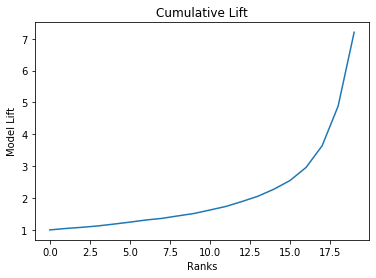

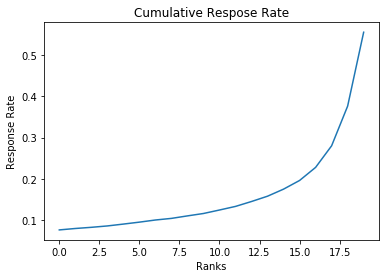

In [10]:
from imp import reload 
import Model
reload(Model)

Lift = Model.ModelLift(c=20)
lift = Lift.calLift(other_test, target='target', prob='prob')
Model.Plot(lift)